# 3.1 - STFT

<img style="float: right; margin:5px 0px 0px 10px" src="img/3.1-Titel.png" width="400">
Die Kurzzeit-Fourier-Transformation (STFT) ist eine Fourier-bezogene Transformation, mit der die Sinusfrequenz und der Phasengehalt lokaler Abschnitte eines Signals bestimmt werden, wenn sie sich im Laufe der Zeit ändern. In der Praxis besteht das Verfahren zum Berechnen von STFTs darin, ein längeres Zeitsignal in kürzere Segmente gleicher Länge zu unterteilen und dann die Fourier-Transformation für jedes kürzere Segment separat zu berechnen. Dies zeigt das Fourier-Spektrum für jedes kürzere Segment. Man zeichnet dann normalerweise die sich ändernden Spektren als Funktion der Zeit auf, die als Spektrogramm oder Wasserfalldiagramm bekannt sind.

## Inhalt  
<table style="width:256px; border: 1px solid black; display: inline-block">
    <tr>
        <td  style="text-align:right" width=64px><img src="img/1-1.png" style="float:left"></td>
        <td style="text-align:left" width=256px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#1'>
                1. Nichtstationäre Signale
            </a>
        </td>
    </tr>  
    <tr>
        <td style="text-align:right"><img src="img/1-2.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#2'>
                2. Fensterung
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/1-3.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#3'>
                3. Kurzzeitspektrum
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/1-4.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#4'>
                4. Anwendungsbeispiel
            </a>
        </td>
    </tr>
</table>

----

<a id='1'></a>
<div>
    <img src="img/1-1.png" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        1. Nichtstationäre Signale 
    </h2>
</div>

Signale, die Realisierungen nichtstationärer Prozesse sind, werden kurz als nichtstationäre Signale bezeichnet.  
Da die Fourier-Transformation nur für stationäre Signale geeignet ist, deren Statistik sich nicht mit der Zeit ändert. Es wird angenommen, dass das Signal zeitunabhängig ist, so dass alle Frequenzbereichsinformationen des Signals erhalten werden können. In der Praxis sind die Signale jedoch häufig nicht stationäre Signale, d.h., sie ändern sich mit der Zeit. Wenn das Spektrum durch Fourier-Transformation analysiert wird, gehen unweigerlich wichtige Zeitinformationen verloren. Daher müssen bei nicht stationären Signalen die lokalen Eigenschaften berücksichtigt werden. Wo es möglich ist, verarbeitet man sie in zeitbegrenzten Segmenten, die als Zeitfenster bezeichnet werden und in denen das Signal als quasistationär betrachtet wird.   

Als Beispiel erzeugen wir einige Signale und analysen die Frequenzgänge:

In [1]:
# Externe Module importieren
import numpy as np
import simpleaudio as sa
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy import fftpack, signal
import librosa
import librosa.display
from IPython.display import clear_output
from scipy.io import wavfile

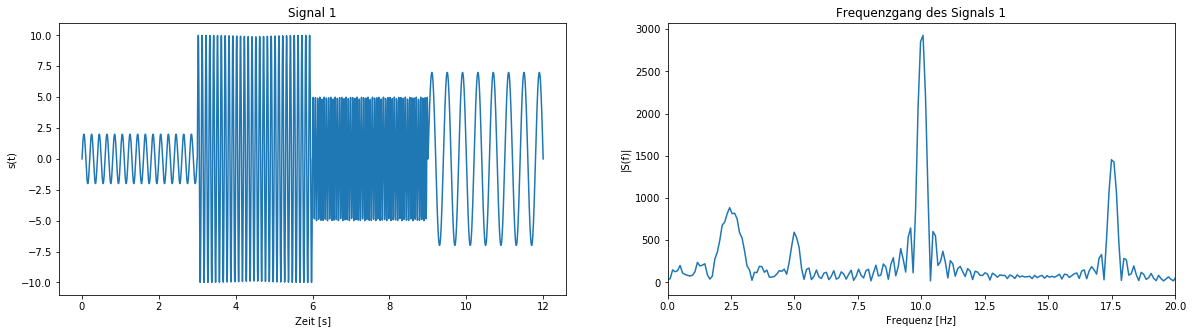

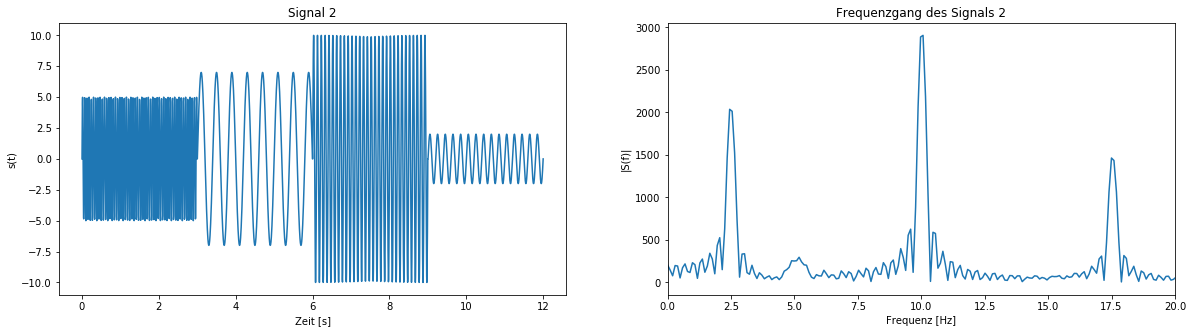

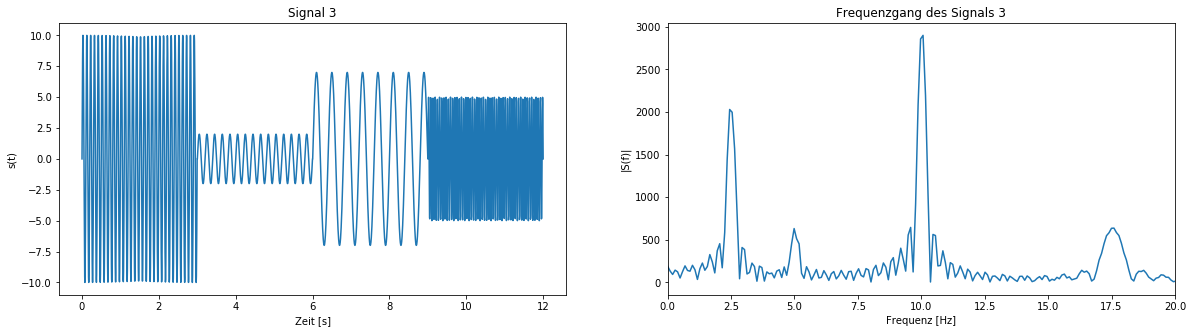

In [2]:
# Initialisierung der Variablen
fs_Hz = 200                                     # Abtrastfrequenz
N = int(2**(np.floor(np.log2(10*fs_Hz))+1))     # Länge von FFT
T_s = 12                                        # Zeitdauer
t_s = np.linspace(0, T_s, T_s*fs_Hz)            # Zeitbereich
t4_s = np.linspace(0, T_s//4, T_s*fs_Hz//4)     # Viertelzeitbereich
f_Hz = np.linspace(0, fs_Hz//2, N//2)           # Frequenzbereich

# 3 Signale mit verschiedenen Zeitreigenb
seg1 = 2 * np.sin(10*np.pi*(t4_s))
seg2 = 10 * np.sin(20*np.pi*t4_s)
seg3 = 5 * np.sin(35*np.pi*t4_s)
seg4 = 7 * np.sin(5*np.pi*t4_s)
s1 = np.array([seg1, seg2, seg3, seg4]).flatten()
s2 = np.array([seg3, seg4, seg2, seg1]).flatten()
s3 = np.array([seg2, seg1, seg4, seg3]).flatten()

# Graphische Darstellung
i = 0
for s in (s1, s2, s3):
    i += 1
    S = np.abs(fftpack.fft(s, N))  # Frequenzgänge
    plt.subplot(121)
    plt.title('Signal %d' %i)
    plt.xlabel('Zeit [s]') 
    plt.ylabel('s(t)') 
    plt.plot(t_s, s)
    plt.subplot(122)
    plt.title('Frequenzgang des Signals %d' %i)
    plt.xlabel('Frequenz [Hz]') 
    plt.xlim(0, 20)
    plt.ylabel('|S(f)|') 
    plt.plot(f_Hz, S[:len(f_Hz)])
    plt.gcf().set_size_inches(20, 5)
    plt.show()

Daraus können wir finden, während das Fourier-Spektrum die Frequenzkomponenten richtig identifiziert, gibt es keine Information darüber, wo diese Harmonischen im Zeitbereich beginnen oder enden. Alle Informationen über den Zeitbereich sind verloren gegangen, da jede Frequenzkomponente eine unendliche Zeitdauer annimmt.

----

<a id='2'></a>
<div>
    <img src="img/1-2.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        2. Fensterung  
    </h2>
</div>

Soweit wir die tatsächlichen Ergebnisse beobachtet haben, können wir die Methode zur Aufteilung des instationären Signals in kurze Segmente, die mehr oder weniger als quasistationär angesehen werden, in Betracht ziehen und das Frequenzspektrum dieser Segmente separat berechnen. Man erhält eine Reihe einzelner Frequenzspektren, die die Dynamik des Signals berücksichtigen. Wenn Sie mit einem zeitkontinuierlichen Signal beginnen, ist die Fourier-Integration natürlich für die Transformation des Signalteils verantwortlich. Dieser Vorgang wird als Kurzzeit-Fourier-Transformation oder STFT (Short-Time Fourier Transform) bezeichnet.

Wir haben bereits in vorherigen Themen gesehen, dass das bloße Ausschneiden eines Signalabschnittes, das einer Multiplikation des Signals mit einem Rechteckfenster entspricht, zu einer Verwischung des Spektrums führt, die durch die Wahl anderer Fensterfunktionen abgemildert werden kann. Aus diesem Grund stellt man auch bei der Kurzzeit-Spektralanalyse die zu analysierenden Signalabschnitte durch Multiplikation des Signals $s(t)$ mit einer geeigneten Fensterfunktion $h(t)$ her. Man spricht dabei vereinfacht von Fensterung oder Zeitfensterung. Die Zeitfensterlänge (der Zeitabschnitt, in dem $h(t)$ von Null verschieden ist), die wir mit $T$ bezeichnet werden, muss mit der gewünschten Dauer des Signalsegments übereinstimmen. 

In [3]:
# Funktion definieren: Dynamische Darstellung
def live_plot(t_s, f_Hz, t, s_win, S_win, slide, s, x_max, y_max):

    plt.ion()
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.set_title('Fensterung des Signals')
    ax1.set_xlabel('Zeit [s]') 
    ax1.set_ylabel('s(t)') 
    ax1.plot(t_s, s)
    ax1.plot(t_s, s_win)
    ax1.plot(t_s, slide)

    ax2.set_title('Frequenzgang des fensterten Signalsegments')
    ax2.set_xlabel('Frequenz [Hz]') 
    ax2.set_ylabel('|S(f)|') 
    ax2.plot(f_Hz, S_win[:len(f_Hz)])
    plt.xlim(0, x_max)
    plt.ylim(0, y_max)    
    
    fig.set_size_inches(20, 5)  
    plt.show()

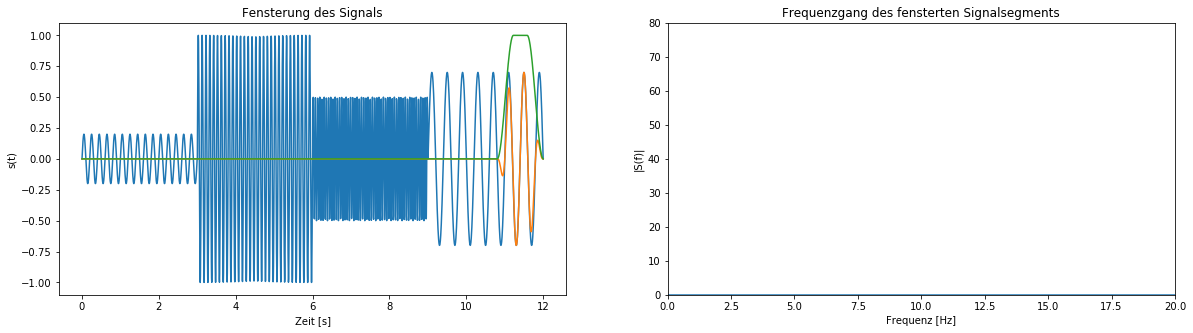

In [4]:
# Dynamische Fensterung des Signals
%matplotlib inline

s = s1/np.max(s1)                               # Signal normalisieren
T = len(s)//10                                  # Fensterlänge
it_s = T//5                                     # Interval
window = signal.get_window(('tukey', 0.7), T)   # Fenster


for t in range(len(t_s)//it_s):
    if (t*it_s + T) > (len(t_s)):
        break        

    slide = np.zeros(len(t_s))
    slide[t*it_s: t*it_s + T] = window
    s_win = s * slide
    S_win = np.abs(fftpack.fft(s_win, N))  

    live_plot(t_s, f_Hz, t, s_win, S_win, slide, s, x_max=20, y_max=80)

Kritisch ist, dass die Wahl der Fensterfunktion $h(t)$ und der Zeitfensterlänge $T$  problemspezifisch erfolgen muss und nur im Zusammenhang mit der Optimierung des konkret vorliegenden Signalmodells gesehen werden kann.

----

<a id='3'></a>
<div>
    <img src="img/1-3.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        3. Kurzzeitspektrum  
    </h2>
</div>

Setzt man den Signalabschnitt als zu transformierende Funktion in das Fourier-Integral ein, erhält man die Hintransformationsgleichung der STFT wie folgt:
\begin{equation}
X(\omega, t)=\int_{-\infty}^{\infty}x(\tau)h(t-\tau)e^{-j\omega \tau}d\tau 
\end{equation} 
Das dabei entstehende Spektrum hat außer der Kreisfrequenz $\omega$ nun auch noch den Analysezeitpunkt $t$ als Variable. Da wir gewöhnlich voraussetzen, dass die Zeitfensterlänge $T$ endlich ist, können die Integrationsgrenzen entsprechend eingeengt werden.  

Mittels [signal.stft()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) oder [librosa.stft()](https://librosa.org/doc/0.8.0/generated/librosa.stft.html) können wir das Spektrum eines Signals berechnen und darstellen. STFT wandelt das Signal so um, dass wir die Amplitude einer bestimmten Frequenz zu einem bestimmten Zeitpunkt kennen. Mit STFT können wir die Amplitude verschiedener Frequenzen bestimmen, die zu einem bestimmten Zeitpunkt eines Signals abgespielt werden:

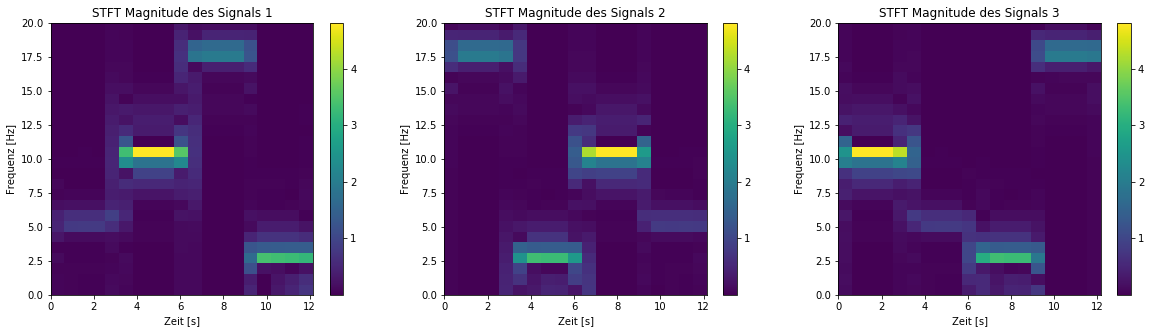

In [5]:
# Kurzzeitspektrum
i = 0
for s in (s1, s2, s3):
    i += 1
    f, t, Zxx = signal.stft(s, fs_Hz, ('tukey', 0.3))  # Frequenzgänge
    plt.subplot(1,3,i)
    plt.pcolormesh(t, f, np.abs(Zxx))
    plt.title('STFT Magnitude des Signals %d' %i)
    plt.xlabel('Zeit [s]') 
    plt.ylabel('Frequenz [Hz]')   
    plt.ylim(0, 20)
    plt.colorbar()

plt.gcf().set_size_inches(20, 5)
plt.show()

Nun ist es anschaulich, welche Frequenzelemente sich in welcher Zeitsegmente befindet, die entsprechen genau unserer Definition der Signale.

Mittels [signal.spectrogram()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) oder [librosa.display.specshow()](https://librosa.org/doc/main/generated/librosa.display.specshow.html) können wir das Spektrogram eines Signals berechnen und darstellen. Ein Spektrogramm ist eine visuelle Darstellung des Spektrums von Schallfrequenzen oder anderen Signalen, die sich mit der Zeit ändern. Es ist eine Darstellung von Frequenzen, die sich in Bezug auf die Zeit für bestimmte Signale wie Musiksignal ändern.

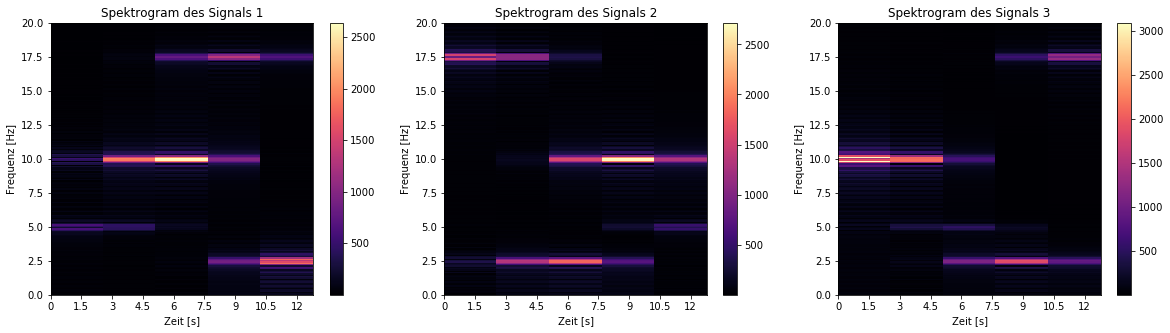

In [6]:
# Spectrogram
i = 0
for s in (s1, s2, s3):
    i += 1
    S = abs(librosa.stft(s)) 

    # (Optional) in dB konvertieren:
    # S_dB = librosa.amplitude_to_db(S)     
    
    plt.subplot(1,3,i)
    librosa.display.specshow(S, sr=fs_Hz, x_axis='s', y_axis='hz')
    plt.title('Spektrogram des Signals %d' %i)
    plt.xlabel('Zeit [s]') 
    plt.ylabel('Frequenz [Hz]')  
    plt.ylim(0, 20)
    plt.colorbar()
    
plt.gcf().set_size_inches(20, 5)
plt.show()

Zum veranschaulichen können wir das Spektrum in 3D visualisieren:

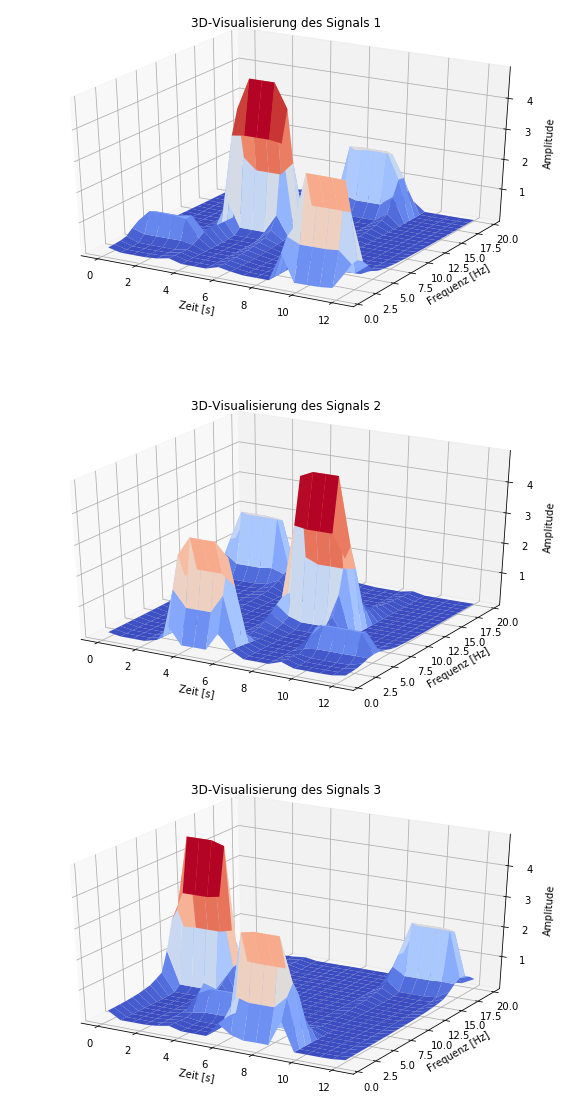

In [7]:
# 3D-Visualisierung
i = 0
fig = plt.figure()
for s in (s1, s2, s3):
    i += 1
    f, t, Zxx = signal.stft(s, fs_Hz)

    fFilter = (f>0) & (f<20)
    f = f[fFilter]
    Zxx = Zxx[fFilter, ...]
    
    ax = fig.add_subplot(3,1,i, projection='3d')
    ax.set_title('3D-Visualisierung des Signals %d' %i)
    ax.set_xlabel('Zeit [s]') 
    ax.set_ylabel('Frequenz [Hz]')  
    ax.set_zlabel('Amplitude')  
    ax.plot_surface(t[None, :], f[:, None], abs(Zxx), cmap=cm.coolwarm)
    
plt.gcf().set_size_inches(10, 20)
plt.show()

----

<a id='4'></a>
<div>
    <img src="img/1-4.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        4. Anwendungsbeispiel  
    </h2>
</div>

Jetzt verwenden Sie bitte STFT zur Analyse eines Musiksignals:

In [8]:
'''
Aufgabe: wav-Datei 'musik.wav' laden und abspielen
'''

# Laden
fsMusic_Hz, musicSignal = wavfile.read('data/musik.wav')
musicSignal = musicSignal/np.max(np.abs(musicSignal))   
musicSignalLength = len(musicSignal)
musicN = int(2**(np.floor(np.log2(10*fsMusic_Hz))+1))      
musicT_s = musicSignalLength/fsMusic_Hz - 1/fsMusic_Hz                      
tMusic_s = np.linspace(0, musicT_s, musicSignalLength)                 
fMusic_Hz = np.linspace(0, fsMusic_Hz/2, musicSignalLength//2)             

# Abspielen
sound = (musicSignal*(2**15-1)/np.max(np.abs(musicSignal))).astype(np.int16)
play_obj = sa.play_buffer(sound, 1, 2, fsMusic_Hz)
play_obj.wait_done()

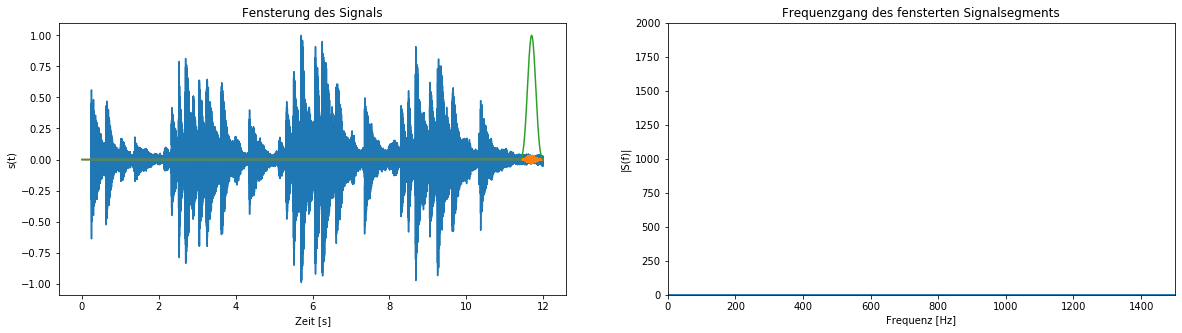

In [9]:
'''
Aufgabe: Dynamische Fensterung darstellen
'''

%matplotlib inline
T = musicSignalLength//20                    
it_s = T//2                                  
window = signal.get_window('blackman', T)     
s = musicSignal

for t in range(musicSignalLength//it_s):
    if (t*it_s + T) > musicSignalLength:
        break        

    slide = np.zeros(musicSignalLength)
    slide[t*it_s: t*it_s + T] = window
    s_win = s * slide
    S_win = np.abs(fftpack.fft(s_win, musicN))  

    live_plot(tMusic_s, fMusic_Hz, t, s_win, S_win, slide, s, x_max=1500, y_max=2000)

Wie gesagt, durch Fensterung werden Frequenzelementen in entsprechenden Zeiträumen bestimmen, das ist genau die unterschiedlichen Tonhöhen beim Musiksignal. Anschließend stellen wir das Spektrogram dar, um die Tonhöhen zu visualisieren:

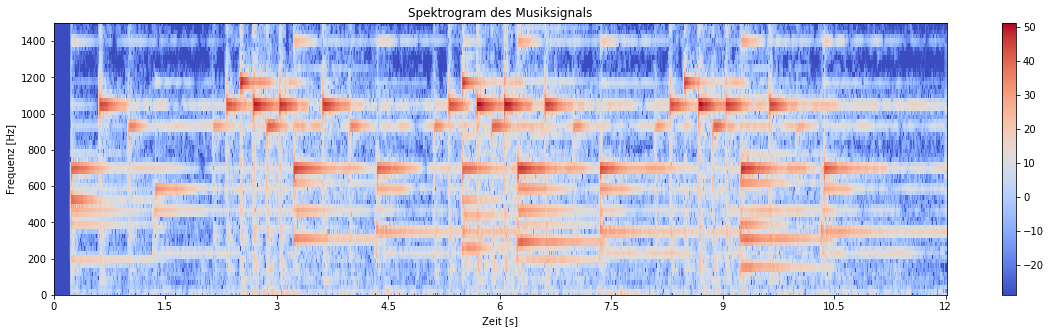

In [10]:
'''
Aufgabe: Spektrogram darstellen
'''

s = musicSignal
S = abs(librosa.stft(s)) 
S_dB = librosa.amplitude_to_db(S)     # in dB konvertieren

librosa.display.specshow(S_dB, sr=fsMusic_Hz, x_axis='s', y_axis='hz')
plt.title('Spektrogram des Musiksignals')
plt.xlabel('Zeit [s]') 
plt.ylabel('Frequenz [Hz]')  
plt.ylim(0, 1500)
plt.colorbar()

plt.gcf().set_size_inches(20, 5)
plt.show()

In diesem Spektrogram sind die Amplitude der Frequenzelementen von ca. $700$ Hz, $900$ Hz, $1000$ Hz usw. deutlich, was entspricht exakt der Tonhöhen $ F_{5} = 698.46$ Hz, $ B^b_{5} = 932.33$ Hz, $ C_{6}=1046.50$ Hz. Wenn Sie Lust haben, können Sie das Spektrogram mit folgenden Musiknoten der Hauptmelodie vergleichen. Die Tabelle für die Beziehung zwischen Tonhöhen und Frequenzen finden Sie unter Referenz \[6].

<img style="float:center; margin:5px 0px 0px 10px" src="img/note.png" width="900">

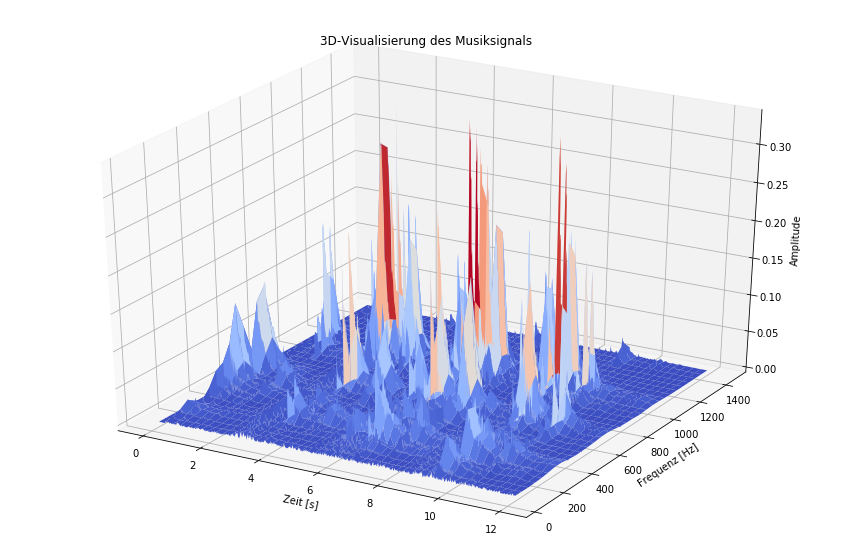

In [11]:
'''
Aufgabe: 3D-Visualisierung
'''

f, t, Zxx = signal.stft(musicSignal, fsMusic_Hz, nperseg=1024)
fFilter = (f>0) & (f<1500)
f = f[fFilter]
Zxx = Zxx[fFilter, ...]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('3D-Visualisierung des Musiksignals')
ax.set_xlabel('Zeit [s]') 
ax.set_ylabel('Frequenz [Hz]')  
ax.set_zlabel('Amplitude')  
ax.plot_surface(t[None, :], f[:, None], abs(Zxx), cmap=cm.coolwarm)
fig.set_size_inches(15, 10)
plt.show()

----

### References

1. Titelbild von [Ethan Weil](https://de.wikipedia.org/wiki/Kurzzeit-Fourier-Transformation#/media/Datei:Short_time_fourier_transform.PNG)  
2. [Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)
3. Lehrbuch: [Intelligente Signalverarbeitung 1 - Signalanalyse](https://katalog.slub-dresden.de/id/0-1654371521/#detail)  
4. Vedio: [The Short Time Fourier Transform | Digital Signal Processing](https://www.youtube.com/watch?v=g1_wcbGUcDY)  
5. [Music Feature Extraction in Python](https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d)   
5. [Frequencies for equal-tempered scale](https://pages.mtu.edu/~suits/notefreqs.html)   